In [1]:
#Este projeto treina usando todas as casas e usando o método 
from __future__ import print_function, division
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

%matplotlib inline

#Tamanho das figuras
rcParams['figure.figsize'] = (13, 6)

In [2]:
#Carrega os dados na memória
train = DataSet('redd.h5')
test = DataSet('redd.h5')

In [3]:
#Enumera todas as casas
buildings = [ i for i in range(1,7,1)]

In [4]:
# The dates are interpreted by Pandas, prefer using ISO dates (yyyy-mm-dd)
train.set_window(end="2011-04-30")
test.set_window(start="2011-04-30")

#Vetor que guarda os dados de todas as casas
train_elec = [None for i in range(7)]
test_elec = [None for i in range(7)]

for building in buildings:
    train_elec[building] = train.buildings[building].elec
    test_elec[building] = test.buildings[building].elec

In [5]:
#Seleciona as top 5 aplicações de cada casa
top_5_train_elec = [None for i in range(7)]

for building in buildings:
    top_5_train_elec[building] = train_elec[building].submeters().select_top_k(k=5)

15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters= for ElecMeterID(instance=3, building=1, dataset='REDD') ...    total_energy for ElecMeterID(instance=4, building=1, dataset='REDD') ...   
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
19/19 MeterGroup(meters==22, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=5)])1)])1)])])
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset=

In [6]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}

    for i, chunk in enumerate(test_elec.mains().load(sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()
    
    
    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    
    return gt_overall, pred_overall

In [7]:
# Since the methods use randomized initialization, let's fix a seed here
# to make this notebook reproducible
import numpy.random
numpy.random.seed(42)

In [34]:
sample_period = 120 
predictions = []
gts = []
fhmm = FHMM()

for building in buildings:
    print('*' * 20 )
    print('Casa : {}'.format(building))
    print('Usando o metodo FHHM...')
    print('*' * 20 )
    fhmm.train(top_5_train_elec[building], sample_period=sample_period)
    gt, prediction = predict(fhmm, test_elec[building], 120, train.metadata['timezone'])
    gts.append(gt)
    predictions.append(prediction)

********************
Casa : 1
Usando o metodo FHHM...
********************
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])' with 3 states
Training model for submeter 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])' with 3 states
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset

IndexError: list index out of range

In [35]:
for i in range(5):
    appliance_labels = [m.label() for m in gts[i].columns.values]
    gts[i].columns = appliance_labels
    predictions[i].columns = appliance_labels

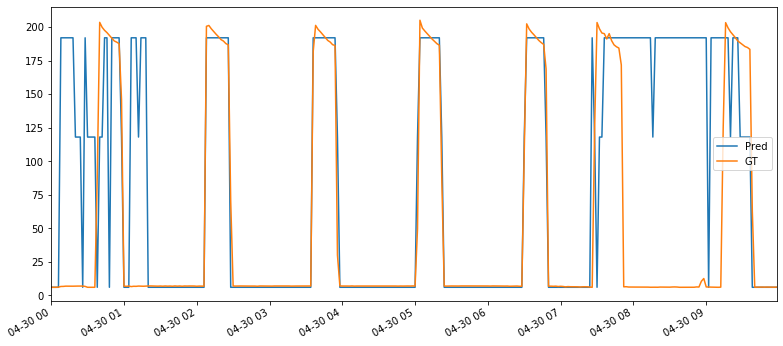

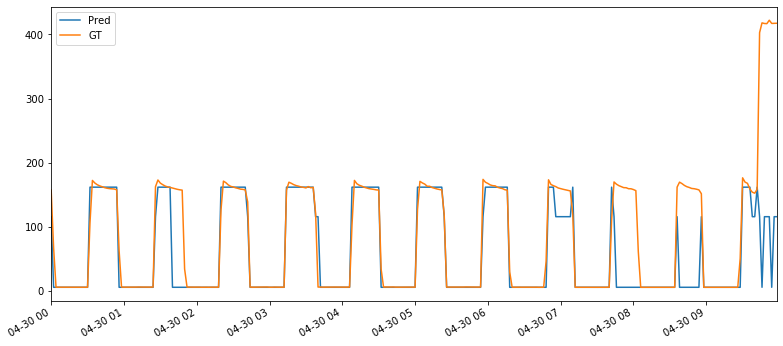

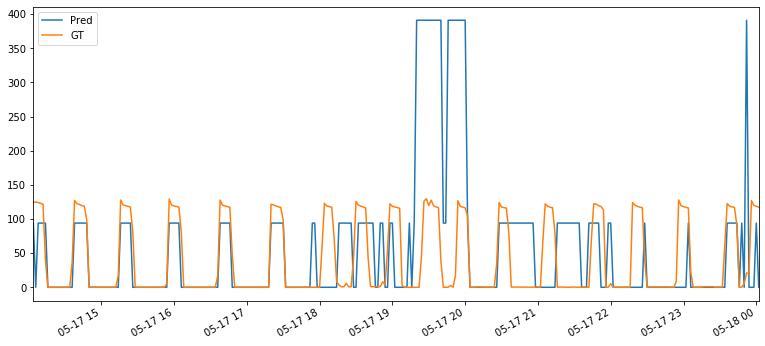

In [51]:
for i in range(3):
    plt.subplots(1)
    predictions[i]['Fridge'].head(300).plot(label="Pred")
    gts[i]['Fridge'].head(300).plot(label="GT")
    plt.legend()


C:\Users\Leona\anaconda3\envs\nilmtk-env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\Leona\anaconda3\envs\nilmtk-env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\Leona\anaconda3\envs\nilmtk-env\lib\site-packages\pandas\plotting\_matplotlib\core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.p

IndexError: list index out of range

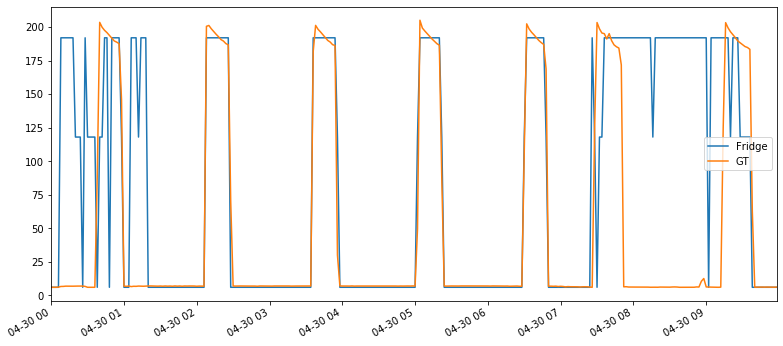

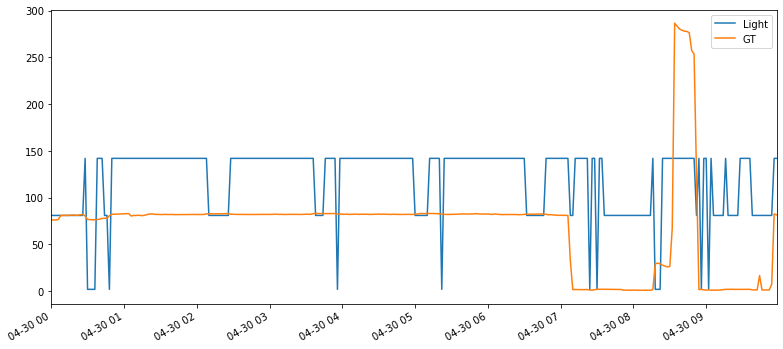

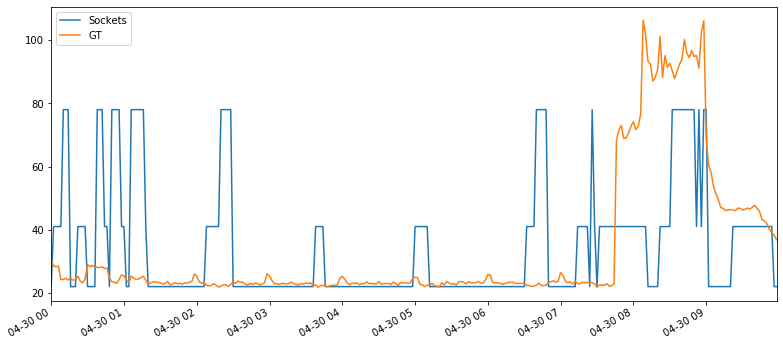

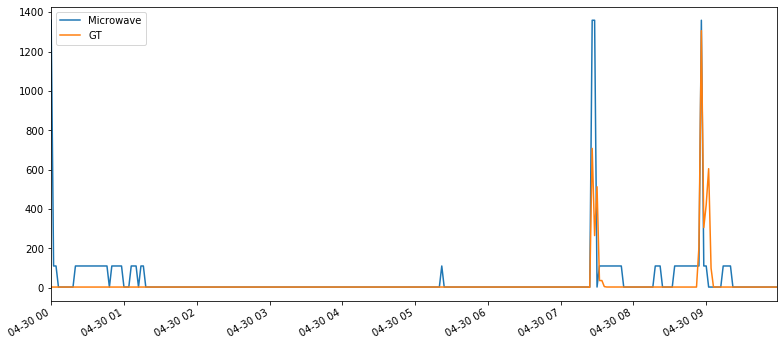

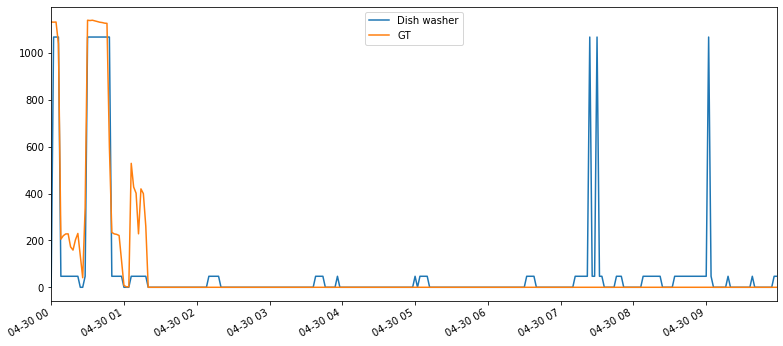

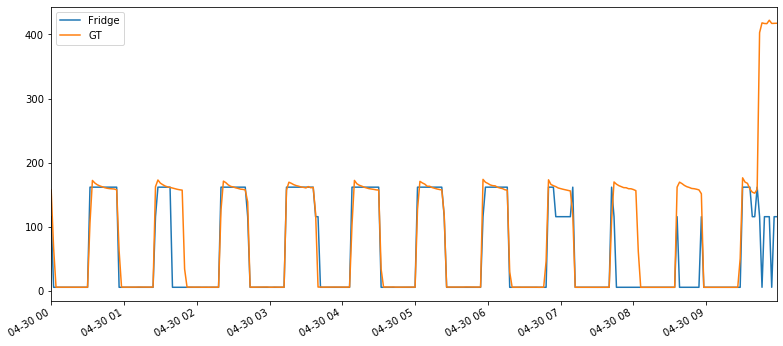

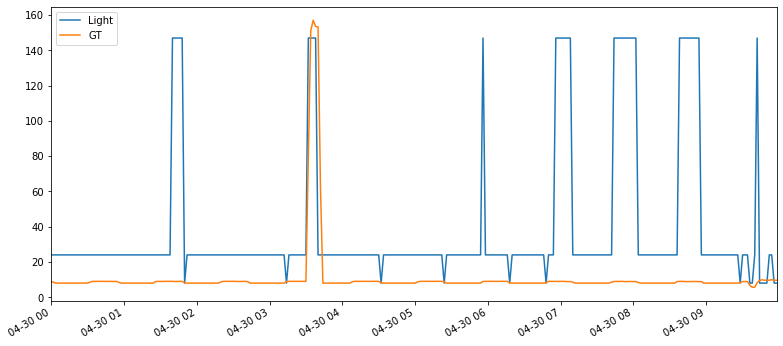

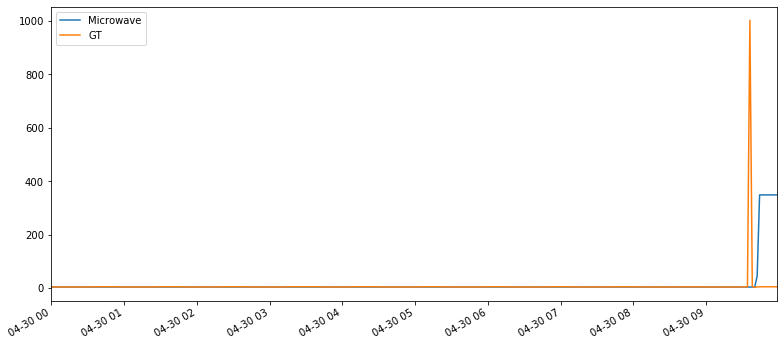

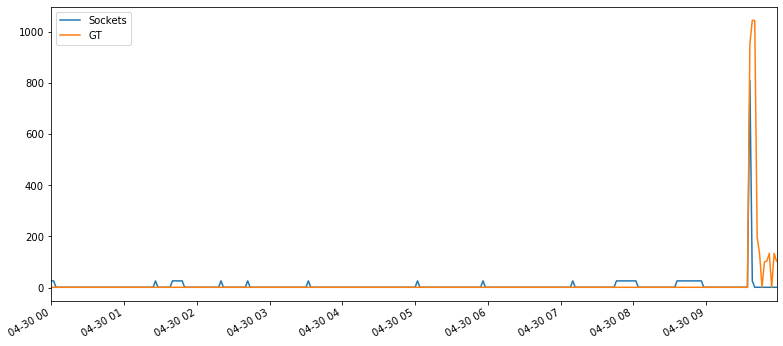

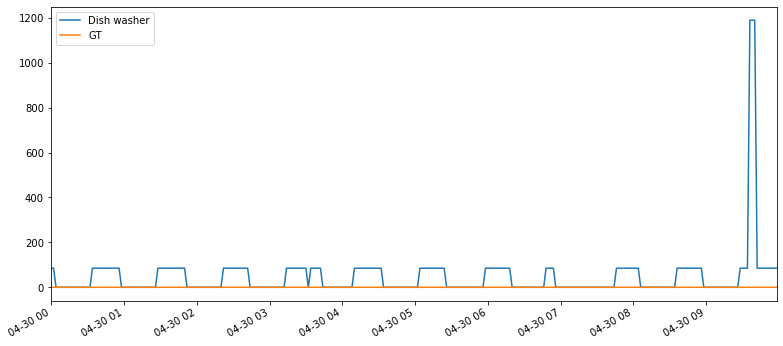

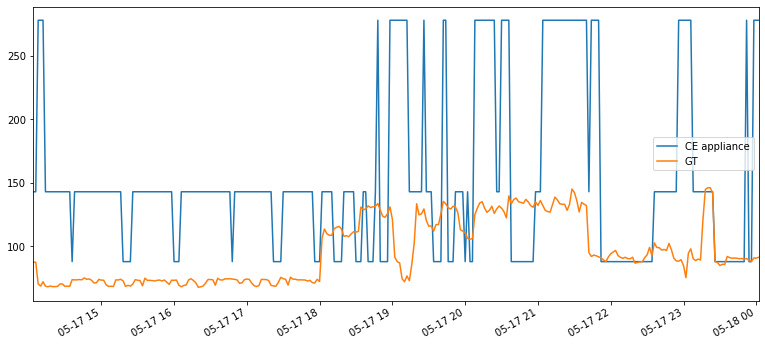

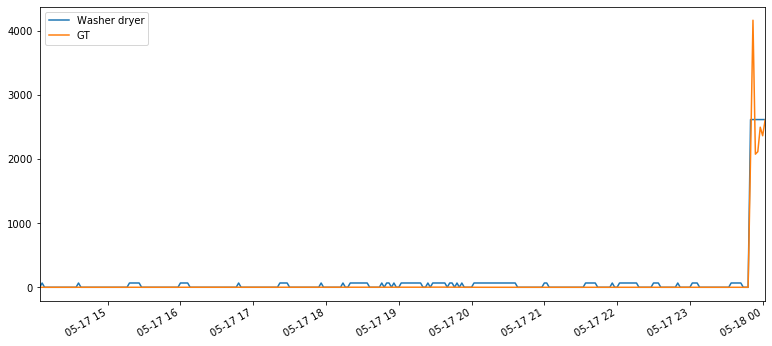

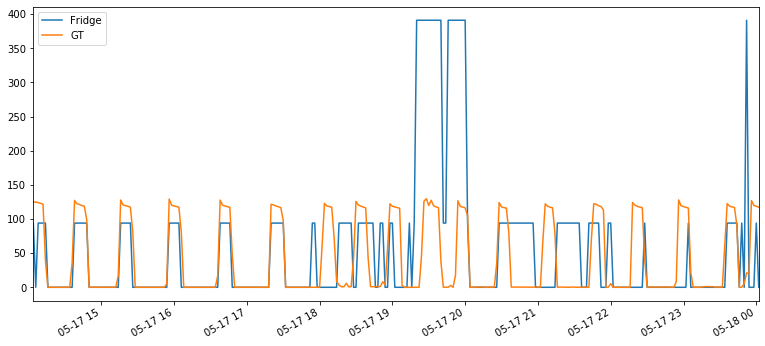

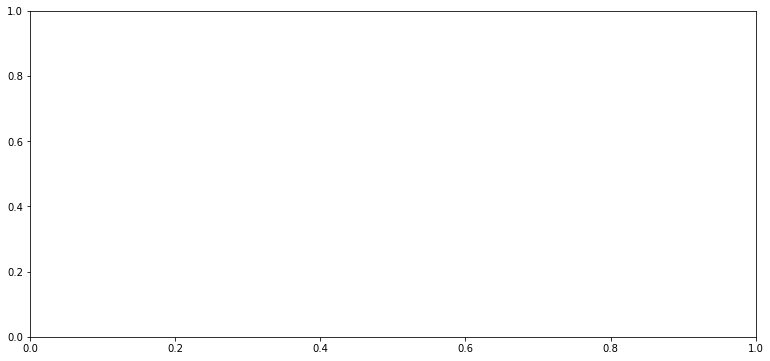

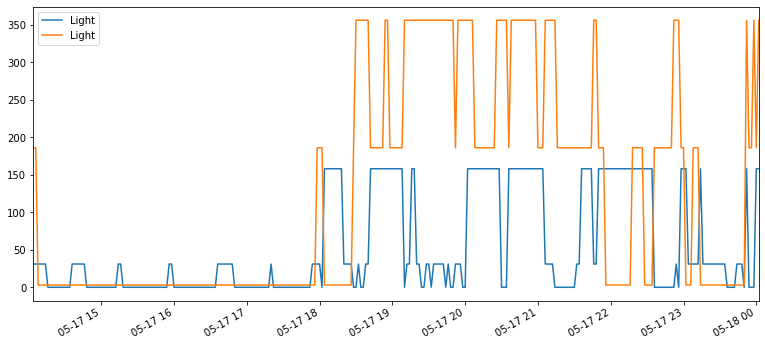

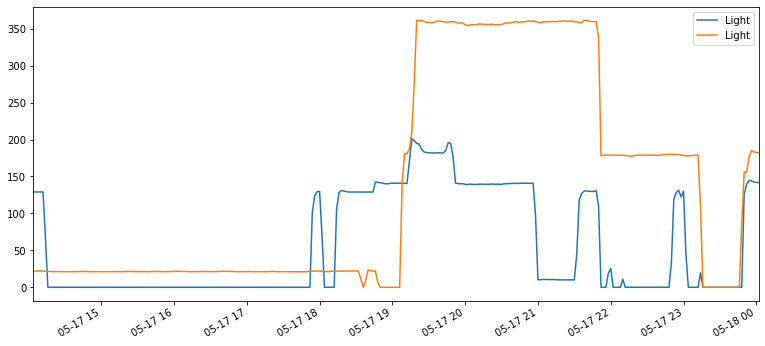

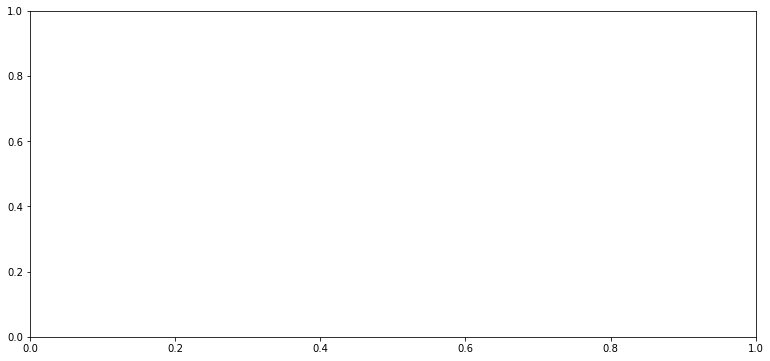

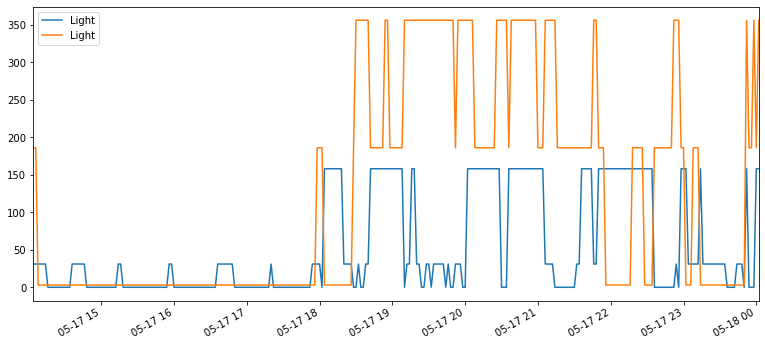

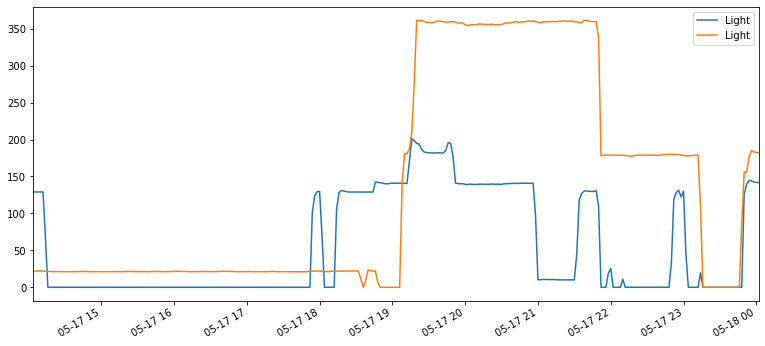

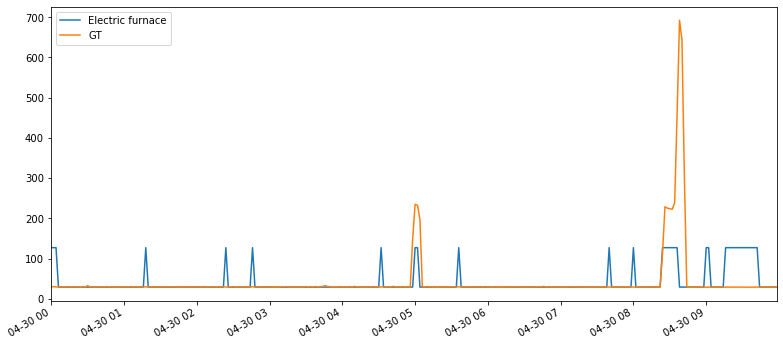

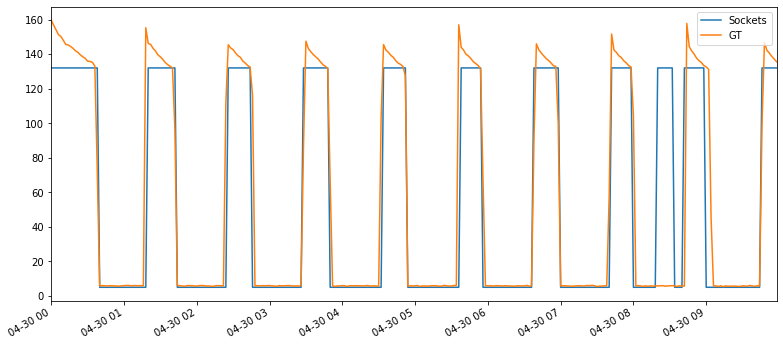

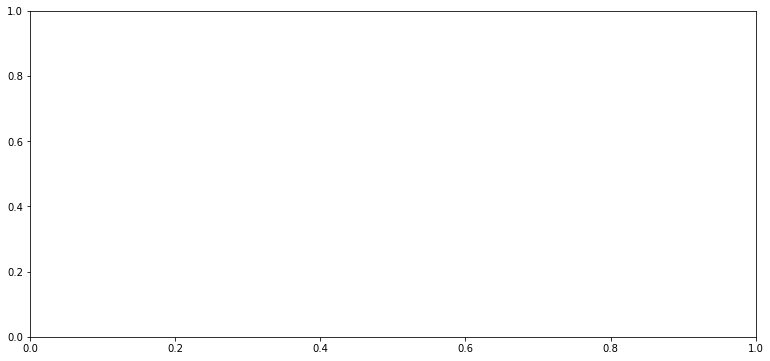

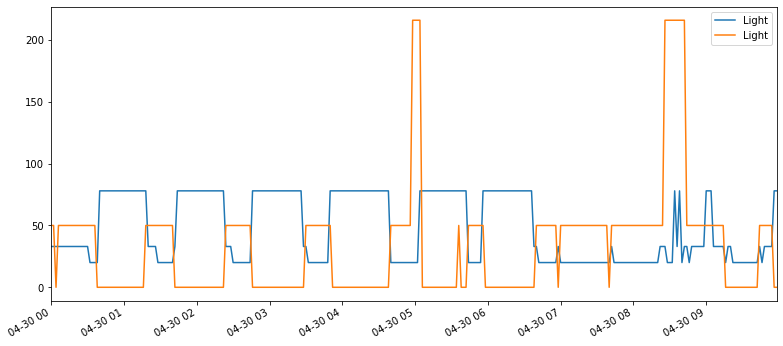

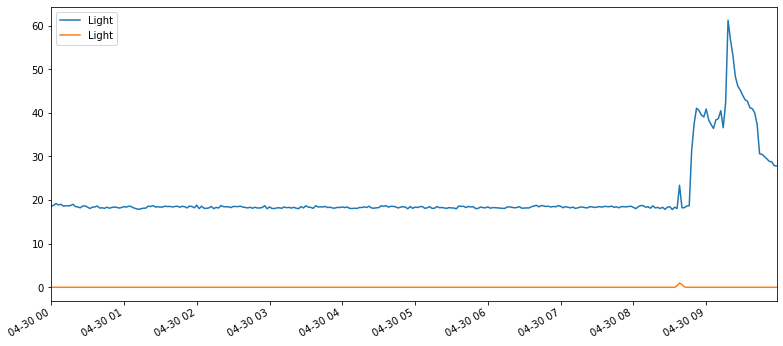

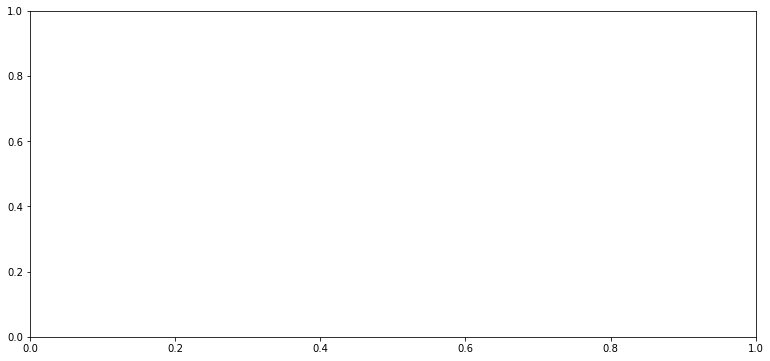

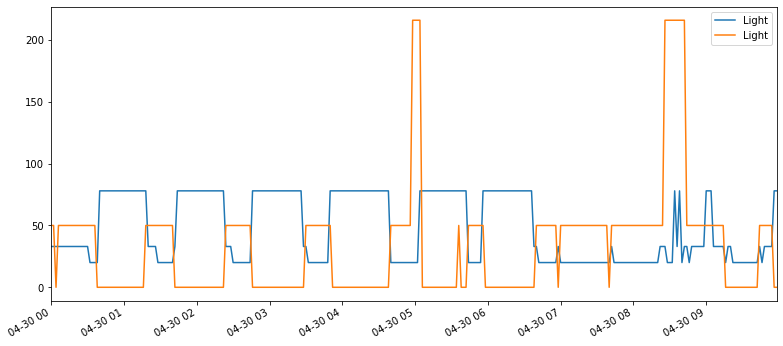

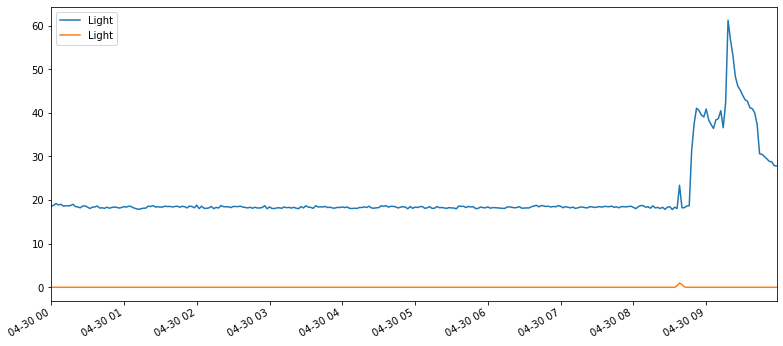

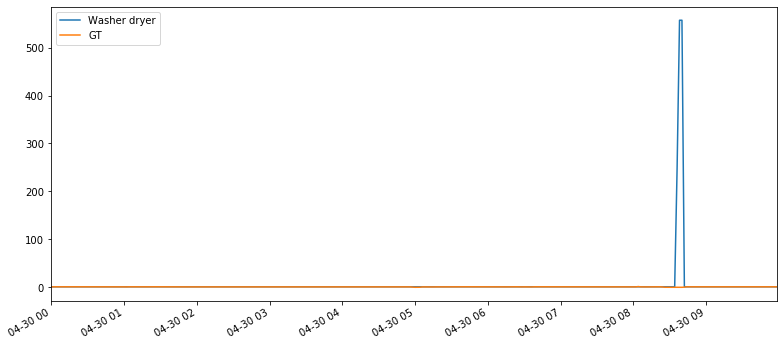

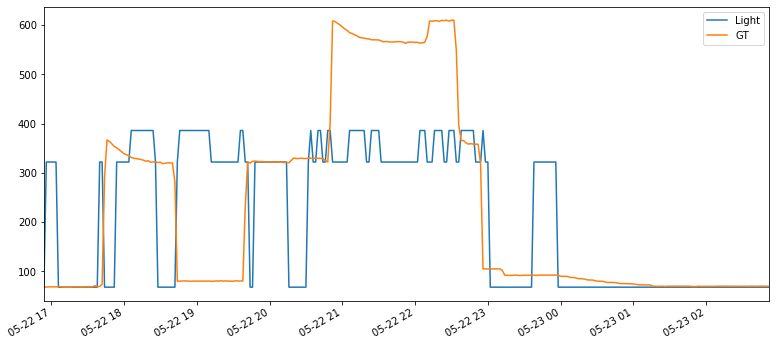

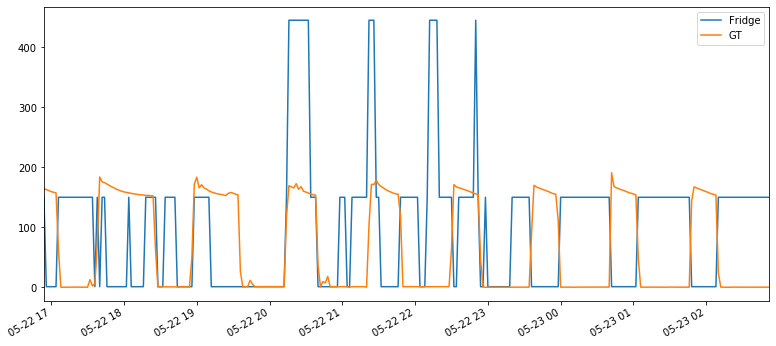

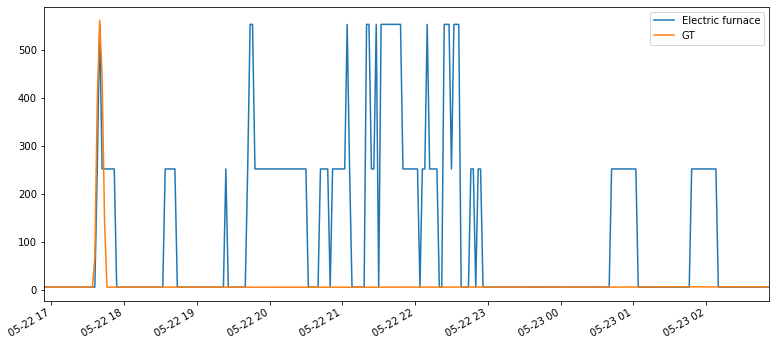

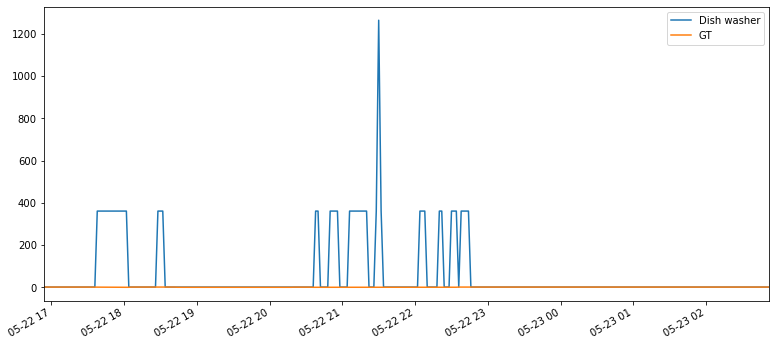

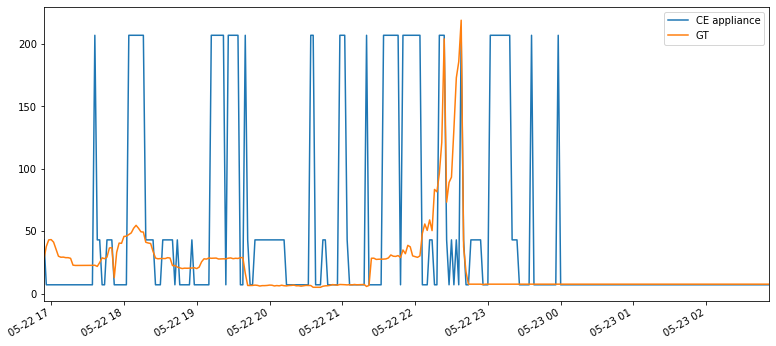

In [60]:
#Imprimindo todas as predições feitas para a casa 1 
for building in buildings:
    for appliance in predictions[building-1]:
        plt.subplots(1)
        predictions[building-1][appliance].head(300).plot(label=appliance)
        gts[building-1][appliance].head(300).plot(label="GT")
        plt.legend()